In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import math
import datetime
from copy import deepcopy as dc
import random
import geometry_bspline as bsp_geom
import NeuralImplicit as NI

In [ ]:
ctrl_pts = bsp_geom.create_star_bspline_control_points(center=(0, 0), outer_radius=1.0, inner_radius=0.5, num_star_points=5, degree=2)
bsp_geom.plot_bspline_distance_field(ctrl_pts, degree=2, N=50)

In [ ]:
def plot_generated_data(fun_num, num_samples=5000):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    coordinates, distances = NI.generate_bspline_data(num_samples,fun_num, device=device)
    coordinates = coordinates.cpu().numpy()
    distances = distances.cpu().numpy()

    plt.figure(figsize=(8, 6))
    sc = plt.scatter(coordinates[:, 0], coordinates[:, 1], c=distances[:, 0], cmap='viridis', s=5)
    plt.colorbar(sc, label='Distance')
    plt.title(f'Generated Data for Function {fun_num}')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.axis('equal')
    plt.show()
plot_generated_data(fun_num=2, num_samples=10000)

In [ ]:
NI.plot_model_weight_per_layer_hyst(model)

In [ ]:
def train_model(model,num_epochs=10):
    report_interval = num_epochs // 10
    criterion = nn.MSELoss()
    star_cp = bsp_geom.create_star_bspline_control_points(center=(0, 0), outer_radius=1.0, inner_radius=0.5, num_star_points=5, degree=1)
    knots = bsp_geom.create_knot_vector(len(star_cp), degree=1)
    L_EIKON = 1e3
    L_BND = 1e4
    L_BND_GRAD = 1e1
    L_XI = 3e2
    NUM_POINTS = 1000
    for epoch in range(num_epochs):
        star_cp = bsp_geom.create_star_bspline_control_points(center=(0, 0), outer_radius=1.0, inner_radius=0.5, num_star_points=5, degree=1)
        boundary_pts, t_values = bsp_geom.generate_points_on_curve(star_cp, num_points=NUM_POINTS, degree=1, device=None, return_t=True)
        other_pts = torch.randn((NUM_POINTS,2))*2-1
        other_pts = other_pts.clone().detach().requires_grad_(True)
        pred_other = model(other_pts)
        grds = torch.autograd.grad(outputs=pred_other, inputs=other_pts, grad_outputs=torch.ones_like(pred_other),retain_graph=True, allow_unused=True, create_graph=True)
        eikonloss = torch.sum(grds[0]**2,dim=1)
        eikonloss_output = torch.abs(1-torch.sqrt(eikonloss)).mean()
        boundary_pts = boundary_pts.clone().detach().requires_grad_(True)
        bond_normal = bsp_geom.bspline_normalvectors(t_values,star_cp,knots,degree=1)
        # elementwise scalar product of bond_normal and gradient of pred_boundary
        pred_boundary = model(boundary_pts)
        grds_boundary = torch.autograd.grad(outputs=pred_boundary, inputs=boundary_pts, grad_outputs=torch.ones_like(pred_boundary),retain_graph=True, allow_unused=True, create_graph=True)
        #print(grds_boundary)
        scalar_prods = torch.sum(grds_boundary[0] * bond_normal, dim=1)
        scalar_loss = torch.abs(1- scalar_prods).mean()
        loss_boundary = torch.abs(torch.mean(torch.abs(pred_boundary)))
        loss_xi = torch.mean(torch.exp(-100*torch.abs(pred_other)))
        loss = L_BND*loss_boundary + L_EIKON*eikonloss_output + L_XI*loss_xi + L_BND_GRAD*scalar_loss
        model.optimizer.zero_grad()
        loss.backward()
        model.optimizer.step()
        model.lr_scheduler.step()
        model.loss_history.append(loss.item())
        if epoch % report_interval == 0:
            CALCULATE_ERROR = False
            if CALCULATE_ERROR:
                pts = torch.randn((5000,2))*2-1
                with torch.no_grad():
                    pred = model(pts)
                    star_sdf = bsp_geom.bspline_signed_distance_vectorized(pts,star_cp,degree=1)
                    error = criterion(pred.squeeze(), star_sdf)
                print(f"Epoch {epoch}, Loss: {loss.item():.6f}, SDF Error: {error.item():.6f}")
                print(f"Losses: Boundary: {L_BND*loss_boundary.item():.6f}, Eikonal: {L_EIKON*eikonloss_output.item():.6f}, Xi: {L_XI*loss_xi.item():.6f}, Scalar prod: {L_BND_GRAD*scalar_loss.item():.6f}")
            else:
                print(f"Epoch {epoch}, Loss: {loss.item():.6f}")
            
train_model(model,100)

In [2]:
architecture = [2,256,256,256,256,256,1]
model = NI.Siren(architecture, outermost_linear=True, first_omega_0=60, hidden_omega_0=60)
print(f"number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
model.optimizer = torch.optim.Adam(lr=1e-5, params=model.parameters())
#model.lr_scheduler = torch.optim.lr_scheduler.StepLR(model.optimizer, step_size=1000, gamma=0.8)
model.lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(model.optimizer, T_max=50000, eta_min=1e-12)


number of parameters: 329985


In [3]:

NI.train_models_with_extras([model],num_epochs = 5000, batch_size = 500, fun_num=3, eikon_coeff=0.0, boundry_coeff=0.2,
                            data_gen_mode='bspline', use_scheduler = True,
                            crt = nn.L1Loss(),create_error_distribution_hystory=True,error_distribution_resolution=100, 
                            create_SDF_history=True, hytory_after_epochs=200)


Epoch [0], Losses: SIREN: 0.269394


c:\Egyetem\Kutatás\NeuralIGA\.venv\lib\site-packages\torch\functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch [499], Losses: SIREN: 0.007578
Epoch [999], Losses: SIREN: 0.005813
Epoch [1499], Losses: SIREN: 0.003993
Epoch [1999], Losses: SIREN: 0.003475
Epoch [2499], Losses: SIREN: 0.003573
Epoch [2999], Losses: SIREN: 0.003111
Epoch [3499], Losses: SIREN: 0.002922
Epoch [3999], Losses: SIREN: 0.002383
Epoch [4499], Losses: SIREN: 0.002811
Epoch [4999], Losses: SIREN: 0.002583


MovieWriter imagemagick unavailable; using Pillow instead.


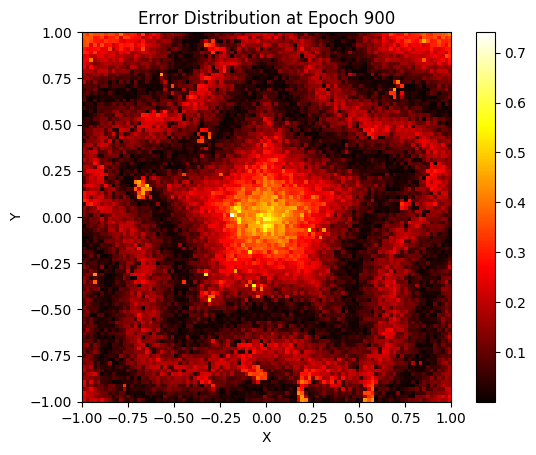

In [7]:
NI.create_animation_error_distribution(model, interval= 500,save_path="test.gif",skip_initial_frames=0, adaptive_scaling=True)

FileNotFoundError: [WinError 2] A rendszer nem találja a megadott fájlt

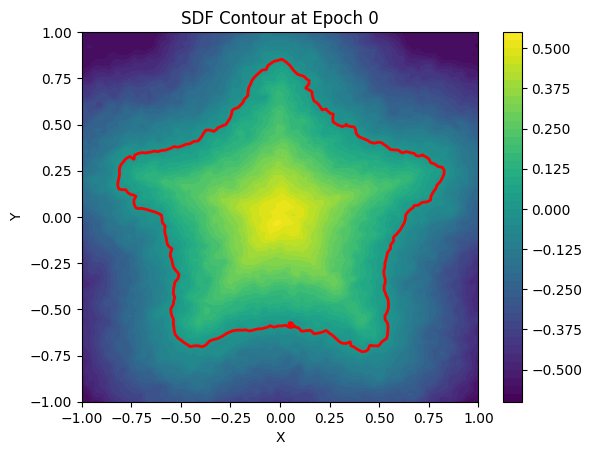

In [4]:
NI.create_animation_SDF_contourf(model, interval=500, save_path="SDF_evolution.mp4", skip_initial_frames=0, adaptive_scaling=False, plot_cntr = True)

MovieWriter imagemagick unavailable; using Pillow instead.


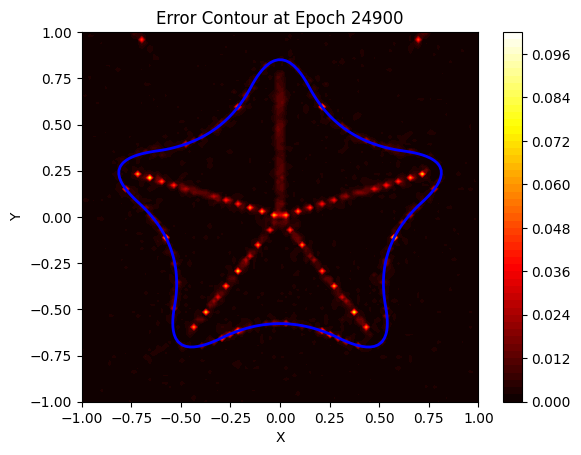

In [25]:
NI.create_animation_error_contourf(model, interval= 500,save_path="error_anim_normal_sched_cos.gif",skip_initial_frames=0, adaptive_scaling=True, plot_cntr = True)

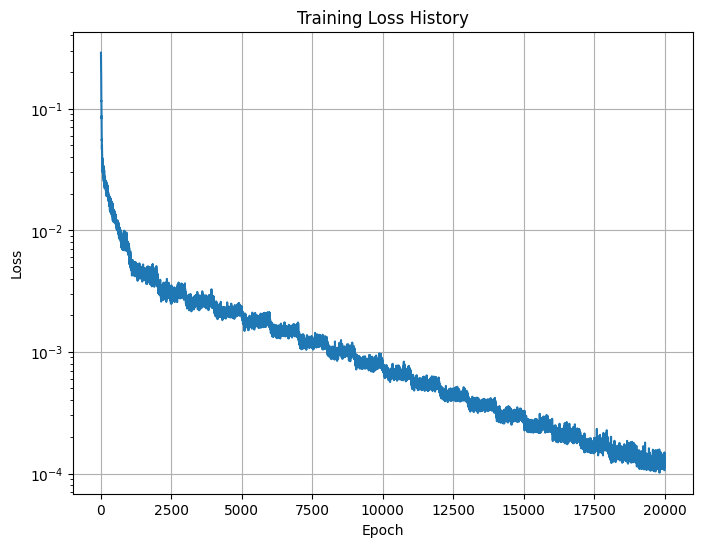

In [5]:
#plot loss history
plt.figure(figsize=(8, 6))
plt.plot(model.loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss History")
plt.grid(True)
plt.yscale('log')
plt.show()

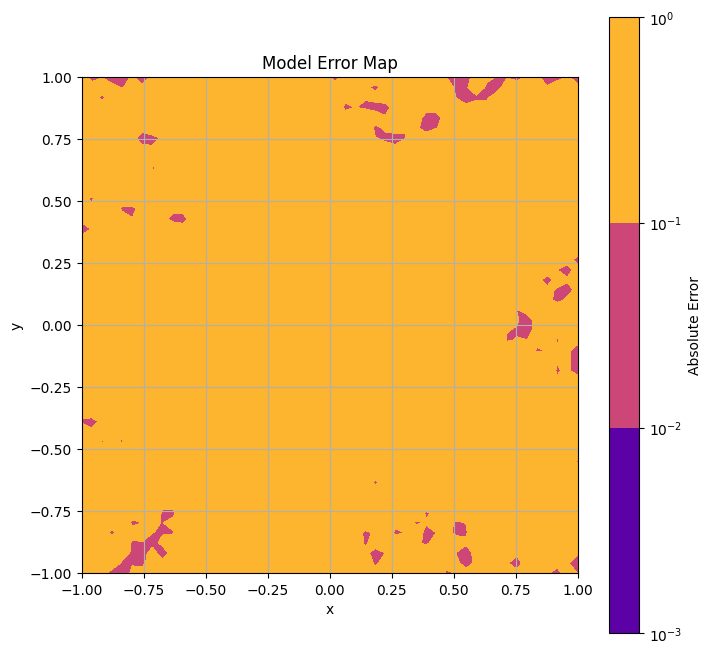

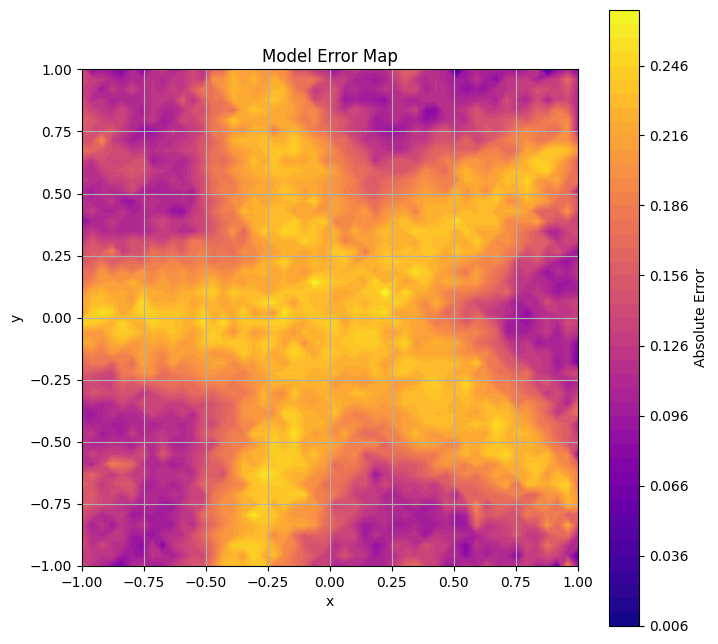

In [7]:
bsp_geom.plot_model_error_map(model,bsp_geom.create_polygon_bspline_control_points(5,1),1,N=50,extent=(-1,1,-1,1), use_log=False)
bsp_geom.plot_model_error_map(model,bsp_geom.create_polygon_bspline_control_points(5,1),1,N=50,extent=(-1,1,-1,1), use_log=True)

In [8]:
def train_model_old(model,num_epochs=10):
    report_interval = num_epochs // 10
    criterion = nn.MSELoss()
    cntrl_pts = bsp_geom.create_polygon_bspline_control_points(5,degree=1)
    knots = bsp_geom.create_knot_vector(len(cntrl_pts), degree=1)
    for epoch in range(num_epochs):
        pts = torch.randn((500,2))*2-1
        #pts = pts.clone().detach().requires_grad_(True)
        pred = model(pts)
        target = bsp_geom.bspline_signed_distance_vectorized(pts,cntrl_pts,degree=1)
        loss_sdf = criterion(pred.squeeze(), target)
        loss = loss_sdf
        model.optimizer.zero_grad()
        loss.backward()
        model.optimizer.step()
        #model.lr_scheduler.step()
        model.loss_history.append(loss.item())
        if epoch % report_interval == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}")
train_model_old(model,100)

Epoch 0, Loss: 4.556866
Epoch 10, Loss: 3.761360
Epoch 20, Loss: 3.181367
Epoch 30, Loss: 2.467447
Epoch 40, Loss: 2.155694
Epoch 50, Loss: 2.265133
Epoch 60, Loss: 1.921426
Epoch 70, Loss: 1.436932
Epoch 80, Loss: 1.295657
Epoch 90, Loss: 1.372169


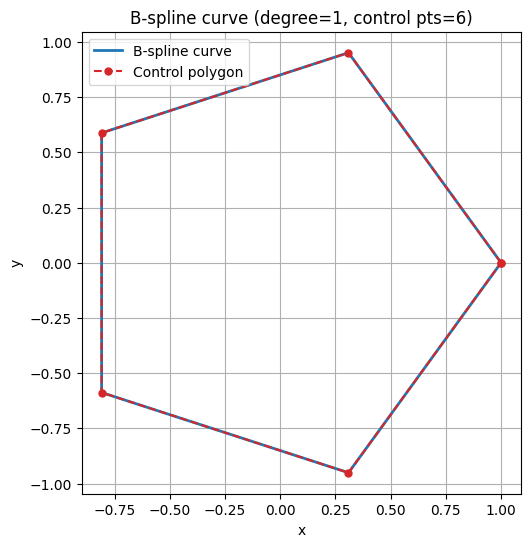

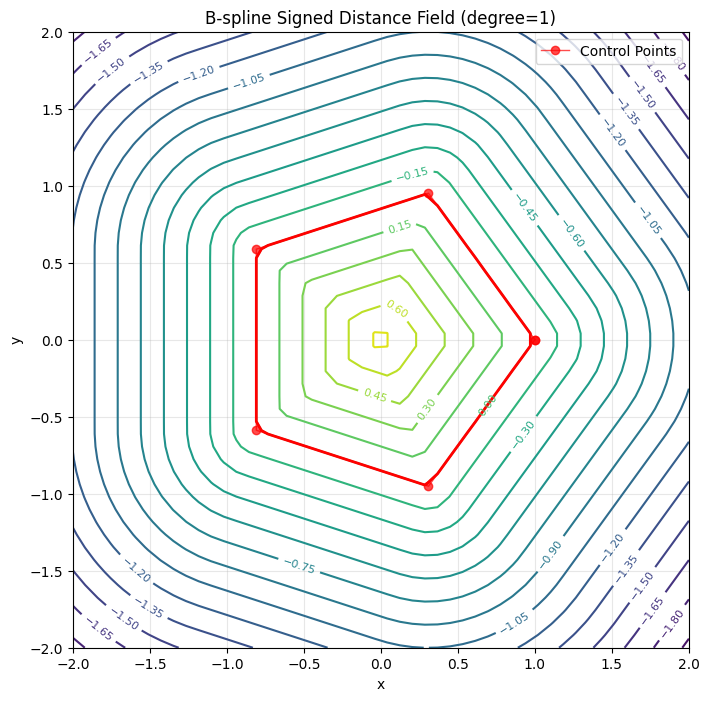

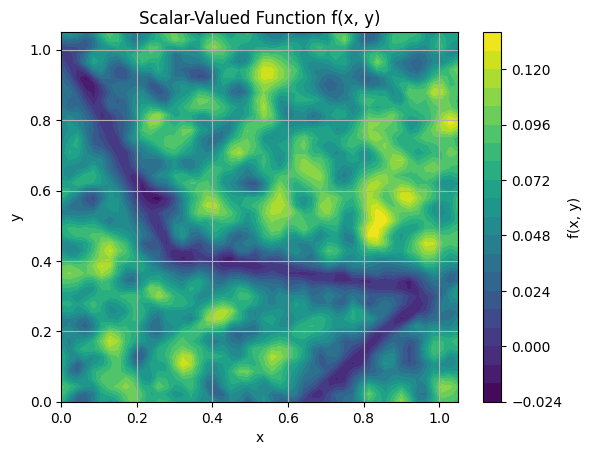

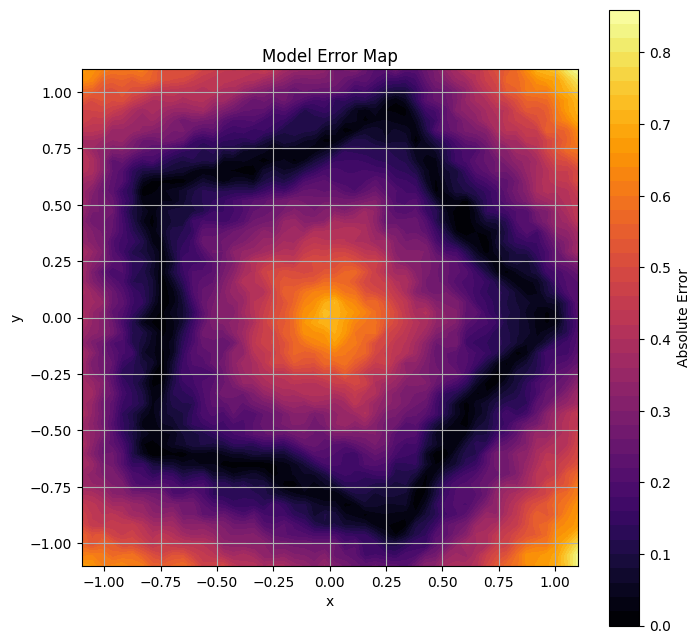

In [14]:
pentagon_cp = bsp_geom.create_polygon_bspline_control_points(5,degree=1)
bsp_geom.plot_bspline_curve(pentagon_cp, degree=1, show_control_points=True)
bsp_geom.plot_bspline_distance_field(pentagon_cp, degree=1, N=50,contour=True)
NI.plotDisctancefunction(model, N=50)
bsp_geom.plot_model_error_map(model, pentagon_cp, degree=1,N=50)

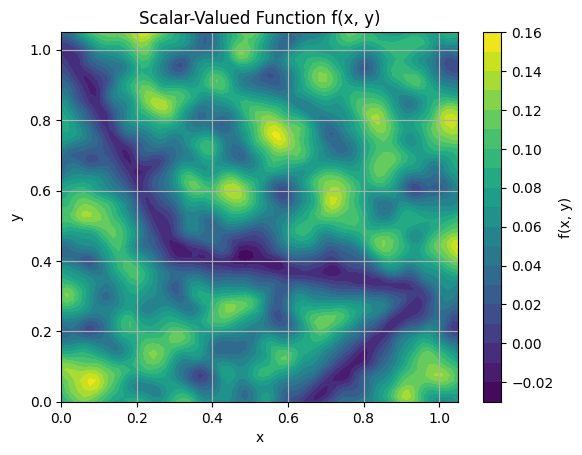

In [ ]:
import NeuralImplicit
NeuralImplicit.plotDisctancefunction(model,70,False)